In [ ]:
#import sys
#!{sys.executable} -m pip install cylp

In [76]:
import numpy as np
import pandas as pd
import scanpy as sc

import plotnine as p9

import liana as li
import decoupler as dc
import omnipath as op
import corneto as cn
import gurobipy

net = dc.get_collectri(organism='mouse')

In [9]:
from plotnine import *

In [10]:
adata = sc.read_h5ad(filename='../data/3_full_anndata.h5ad')

In [11]:
dge_res=pd.read_csv('../results/dge_res.csv')
dge_res['coef'] = pd.Categorical(dge_res.coef)

In [12]:
comparisons = dge_res['coef'].unique()[::-1]

In [13]:
comparisons

['HDAC_WT_vs_NoT', 'HDAC_cKO_vs_NoT', 'HDAC_cKO_vs_HDAC_WT']
Categories (3, object): ['HDAC_WT_vs_NoT', 'HDAC_cKO_vs_HDAC_WT', 'HDAC_cKO_vs_NoT']

In [7]:
def differential_interactions(comp, org, exp):
    dge = dge_res.query('coef == @comp & organ == @org & experiment == @exp')
    dge = dge.set_index('rn')
    dge = dge.rename(columns={'t':'t_stat'})
    cond = comp[0:comp.find('_vs_')]
    subset = adata[(adata.obs['treatment.agg'] == cond) & (adata.obs['organ'] == org) & (adata.obs['experiment'] == exp)].copy()
    df = li.multi.df_to_lr(subset, 
                           dea_df=dge, 
                           groupby='celltype', 
                           resource_name='mouseconsensus',
                           stat_keys=['t_stat', 'P.Value', 'adj.P.Val', 'B'],
                           complex_col='t_stat',
                           expr_prop=0.1,
                           use_raw=False, 
                           verbose=True,
                           return_all_lrs=False)
    return(df)

In [14]:
organ = adata.obs['organ'].copy().unique()
experiment = adata.obs['experiment'].copy().unique()

In [15]:
lr_res={f'{i}-{j}-{m}':differential_interactions(i, j, m) for i in comparisons for j in organ for m in experiment}

Using resource `mouseconsensus`.
Using `.X`!
/home/people/lerlmeier/Apps/pyenv/lib/python3.11/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
11484 features of mat are empty, they will be removed.
/home/people/lerlmeier/Apps/pyenv/lib/python3.11/site-packages/liana/method/_pipe_utils/_pre.py:148: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/home/people/lerlmeier/Apps/pyenv/lib/python3.11/site-packages/liana/method/_pipe_utils/_pre.py:151: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The following cell identities were excluded: Endothelial_cells, Fibroblasts_5, Keratinocytes_5, T_gd_4, removed_B
0.45 of entities in the resource are missing from the data.
Using resour

Using resource `mouseconsensus`.
Using `.X`!
/home/people/lerlmeier/Apps/pyenv/lib/python3.11/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
10795 features of mat are empty, they will be removed.
/home/people/lerlmeier/Apps/pyenv/lib/python3.11/site-packages/liana/method/_pipe_utils/_pre.py:148: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/home/people/lerlmeier/Apps/pyenv/lib/python3.11/site-packages/liana/method/_pipe_utils/_pre.py:151: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The following cell identities were excluded: Fibroblasts_5, Keratinocytes_3, Keratinocytes_4, Keratinocytes_8, removed_B
0.44 of entities in the resource are missing from the data.
Using

In [16]:
lr_res = pd.concat(lr_res.values(), keys = lr_res.keys())
lr_res = lr_res.reset_index(level=0)
lr_res = lr_res.rename({'level_0':'analysis'}, axis=1)
lr_res[['comparison', 'organ', 'experiment']] = lr_res['analysis'].str.split('-', expand = True)
lr_res[['contrast', 'intercept']] = lr_res['comparison'].str.split('_vs_', expand = True)

In [17]:
lr_res

,analysis,ligand,receptor,ligand_complex,receptor_complex,source,ligand_t_stat,ligand_P.Value,ligand_adj.P.Val,ligand_B,...,interaction_adj.P.Val,interaction_B,interaction_expr,interaction_props,interaction,comparison,organ,experiment,contrast,intercept
0,HDAC_WT_vs_NoT-LN-HDAC1,Adam10,Cd44,Adam10,Cd44,B_follicular,-0.921881,3.710220e-01,0.602070,-6.304641,...,0.681898,-6.375631,0.279142,0.228862,Adam10^Cd44,HDAC_WT_vs_NoT,LN,HDAC1,HDAC_WT,NoT
1,HDAC_WT_vs_NoT-LN-HDAC1,Adam10,Notch2,Adam10,Notch2,B_follicular,-0.921881,3.710220e-01,0.602070,-6.304641,...,0.444317,-5.908855,0.404475,0.319057,Adam10^Notch2,HDAC_WT_vs_NoT,LN,HDAC1,HDAC_WT,NoT
2,HDAC_WT_vs_NoT-LN-HDAC1,Icam1,Itgal,Icam1,Itgal_Itgb2,B_follicular,-0.518144,6.118327e-01,0.792304,-6.518374,...,0.678942,-6.342205,0.229876,0.191567,Icam1^Itgal_Itgb2,HDAC_WT_vs_NoT,LN,HDAC1,HDAC_WT,NoT
4,HDAC_WT_vs_NoT-LN-HDAC1,Icam1,Il2rg,Icam1,Il2rg,B_follicular,-0.518144,6.118327e-01,0.792304,-6.518374,...,0.849986,-6.837480,0.870288,0.512174,Icam1^Il2rg,HDAC_WT_vs_NoT,LN,HDAC1,HDAC_WT,NoT
5,HDAC_WT_vs_NoT-LN-HDAC1,Fcer2a,Cr2,Fcer2a,Cr2,B_follicular,-8.781629,2.460473e-07,0.001073,7.167220,...,0.062554,1.356951,1.221111,0.699867,Fcer2a^Cr2,HDAC_WT_vs_NoT,LN,HDAC1,HDAC_WT,NoT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170864,HDAC_cKO_vs_HDAC_WT-Skin-HDAC2,Il1f9,Ifnar2,Il1f9,Ifnar2,removed_T,1.996563,4.588033e-02,0.988870,-3.916621,...,0.988870,-4.216432,0.460640,0.382353,Il1f9^Ifnar2,HDAC_cKO_vs_HDAC_WT,Skin,HDAC2,HDAC_cKO,HDAC_WT
170865,HDAC_cKO_vs_HDAC_WT-Skin-HDAC2,Gstp1,Traf2,Gstp1,Traf2,removed_T,-0.936927,3.488027e-01,0.988870,-4.836518,...,0.988870,-4.820704,0.416172,0.323529,Gstp1^Traf2,HDAC_cKO_vs_HDAC_WT,Skin,HDAC2,HDAC_cKO,HDAC_WT
170866,HDAC_cKO_vs_HDAC_WT-Skin-HDAC2,H2-T23,Cd8b1,H2-T23,Cd8b1,removed_T,0.099953,9.203819e-01,0.993068,-5.185354,...,0.990969,-5.033797,0.873871,0.485294,H2-T23^Cd8b1,HDAC_cKO_vs_HDAC_WT,Skin,HDAC2,HDAC_cKO,HDAC_WT
170867,HDAC_cKO_vs_HDAC_WT-Skin-HDAC2,Gm7030,Cd8b1,Gm7030,Cd8b1,removed_T,0.466248,6.410412e-01,0.988870,-4.903139,...,0.988870,-4.892689,0.166941,0.132353,Gm7030^Cd8b1,HDAC_cKO_vs_HDAC_WT,Skin,HDAC2,HDAC_cKO,HDAC_WT


In [18]:
lr_res.to_csv('../results/liana_res_dge.csv', index=False)

In [ ]:
lr_res = pd.read_csv('../results/liana_res_dge.csv')

array([[<Axes: title={'center': 'HDAC_WT_vs_NoT-LN-HDAC1'}>,
        <Axes: title={'center': 'HDAC_WT_vs_NoT-LN-HDAC2'}>,
        <Axes: title={'center': 'HDAC_WT_vs_NoT-Skin-HDAC1'}>],
       [<Axes: title={'center': 'HDAC_WT_vs_NoT-Skin-HDAC2'}>,
        <Axes: title={'center': 'HDAC_cKO_vs_HDAC_WT-LN-HDAC1'}>,
        <Axes: title={'center': 'HDAC_cKO_vs_HDAC_WT-LN-HDAC2'}>],
       [<Axes: title={'center': 'HDAC_cKO_vs_HDAC_WT-Skin-HDAC1'}>,
        <Axes: title={'center': 'HDAC_cKO_vs_HDAC_WT-Skin-HDAC2'}>,
        <Axes: title={'center': 'HDAC_cKO_vs_NoT-LN-HDAC1'}>],
       [<Axes: title={'center': 'HDAC_cKO_vs_NoT-LN-HDAC2'}>,
        <Axes: title={'center': 'HDAC_cKO_vs_NoT-Skin-HDAC1'}>,
        <Axes: title={'center': 'HDAC_cKO_vs_NoT-Skin-HDAC2'}>]],
      dtype=object)

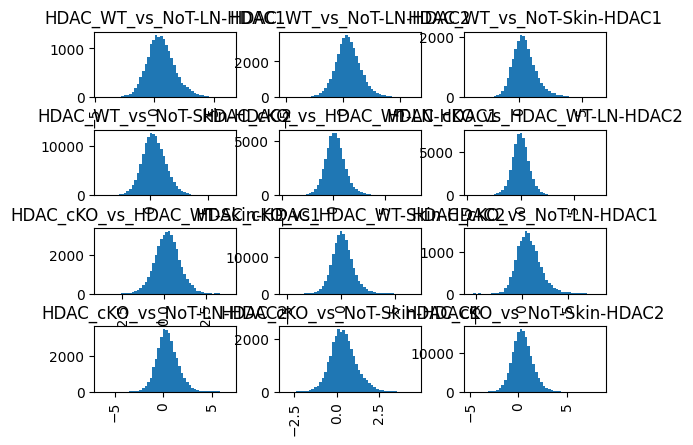

In [19]:
lr_res = lr_res.sort_values(['interaction_t_stat', 'analysis'], ascending=[False,True])

lr_res.hist(bins=50, by = 'analysis', column = 'interaction_t_stat')

In [ ]:
for i in lr_res['analysis'].unique():
    df = lr_res.query('analysis == @i')
    exp = df['experiment'].unique()[0]
    org = df['organ'].unique()[0]
    con = df['contrast'].unique()[0]
    inter = df['intercept'].unique()[0]

    f = (li.pl.tileplot(liana_res=df,
                       fill='expr',
                       label='adj.P.Val',
                       label_fun = lambda x: '*' if x < 0.05 else np.nan,
                       top_n=15,
                       orderby = 'interaction_t_stat',
                       orderby_ascending = False,
                       orderby_absolute = False,
                       source_title='Ligand',
                       target_title='Receptor',
                       figure_size=(11,10)
                      ) +
         p9.ggtitle(f'{con} vs {inter} | {org} | {exp}'))
    f.save(f'../plots/{con}_vs_{inter}_{org}_{exp}.pdf')
    


In [20]:
t = lr_res.query('contrast == "HDAC_cKO" & intercept == "HDAC_WT" & experiment == "HDAC2"')

In [21]:
t_n_inter=t.query('`interaction_adj.P.Val`<0.05').groupby(['source', 'target', 'organ'], as_index=False, observed=True)['interaction_props'].agg(count='count')


In [22]:
t_n_inter

,source,target,organ,count
0,Fibroblasts_2,Fibroblasts_2,Skin,4
1,Fibroblasts_2,Keratinocytes_3,Skin,2
2,Fibroblasts_2,Macrophages_3,Skin,1
3,Fibroblasts_2,Monocytes,Skin,1
4,Fibroblasts_2,T_CD45.1_2,Skin,1
...,...,...,...,...
80,Unassigned3,T_CD45.1_2,Skin,2
81,Unassigned3,T_CD45.1_3,Skin,4
82,Unassigned3,T_gd_3,Skin,2
83,Unassigned3,removed_B,Skin,1


In [23]:
p=(ggplot(t_n_inter)+
   geom_tile(aes('source','target', fill='count'))+
   facet_grid('~organ', scales = 'free', space = 'free')+
   scale_fill_gradient(low = '#fee0d2', high = '#de2d26')+
   theme_bw()+
   theme(axis_text_x=element_text(rotation = 90)))

p.save('../plots/n_dge_interactions_HDAC_cKO.pdf', width=10, height = 10)

/home/people/lerlmeier/Apps/pyenv/lib/python3.11/site-packages/plotnine/ggplot.py:604: PlotnineWarning: Saving 10 x 10 in image.
/home/people/lerlmeier/Apps/pyenv/lib/python3.11/site-packages/plotnine/ggplot.py:605: PlotnineWarning: Filename: ../plots/n_dge_interactions_HDAC_cKO.pdf
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


In [ ]:
cut_plot = (li.pl.dotplot(liana_res=t,
                     colour='interaction_t_stat',
                     size='ligand_adj.P.Val',
                     inverse_size=True,
                     source_labels=['T_CD45.1_2', 'Neutrophils',
                                   'Monocytes', 'T_CD45.1_3'],
                     target_labels=['T_CD45.1_2', 'Neutrophils',
                                   'Monocytes', 'T_CD45.1_3'],
                     orderby='interaction_t_stat',
                     orderby_ascending=False,
                     orderby_absolute=True,
                     top_n=20,
                     size_range=(0.5, 4)
                     )

# customize plot

    + p9.theme_bw(base_size=14)
    # fill cmap blue to red, with 0 the middle
    + p9.scale_color_gradient2(low = 'blue', high = 'red', mid = 'white')
    # rotate x
    + p9.theme(axis_text_x=p9.element_text(angle=90), figure_size=(11, 6))

           )

In [ ]:
cut_plot.save('../plots/top_differential_interactions_HDAC_cKO.pdf')

In [ ]:
plot = (li.pl.dotplot(liana_res=lr_res,
                     colour='interaction_t_stat',
                     size='interaction_adj.P.Val',
                     inverse_size=True,
                     orderby='interaction_t_stat',
                     orderby_ascending=False,
                     orderby_absolute=True,
                     top_n=15,
                     size_range=(0.5, 4)
                     ) 
+ p9.theme_bw(base_size=14)
                        # fill cmap blue to red, with 0 the middle
                        
        + p9.scale_colour_gradient2(low = 'blue', mid = 'white', high = 'red')
                        # rotate x
                       
                + p9.theme(axis_text_x=p9.element_text(angle=90)))

#tooo large

In [ ]:
plot.save('../plots/all_differential_interactions_HDAC_WT.pdf', width = 60, height = 10, limitsize=False)

In [24]:
def select_top_n(d, n=None):
    d = dict(sorted(d.items(), key=lambda item: abs(item[1]), reverse=True))
    return {k: v for i, (k, v) in enumerate(d.items()) if i < n}

In [28]:
source_label = 'Keratinocytes_4'
target_label = 'T_gd_3'

# NOTE: We sort by the absolute value of the interaction stat
lr_stats = lr_res[(lr_res['interaction_adj.P.Val'] < 0.05) & (lr_res['analysis'] == 'HDAC_cKO_vs_HDAC_WT-Skin-HDAC2') & lr_res['source'].isin([source_label]) & lr_res['target'].isin([target_label])].copy()
lr_stats = lr_stats.sort_values('interaction_t_stat', ascending=False, key=abs)

In [29]:
lr_dict = lr_stats.set_index('receptor')['interaction_t_stat'].to_dict()
input_scores = select_top_n(lr_dict, n=15)

In [30]:
input_scores

{'Cd4': 4.60287303183383, 'Ptprj': 3.59204150294253, 'Itga4': 0.9421746586058}

In [59]:
dge=dge_res.query('organ == "Skin" & experiment == "HDAC2" & treatment =="KO_vs_WT"')

In [60]:
# First, let's transform the DEA statistics into a DF
# we will use these to estimate deregulated TF activity
dge_wide = dge[['celltype', 't', 'rn']].pivot(index='celltype', columns='rn', values='t')
dge_wide = dge_wide.fillna(0)

In [61]:
net = dc.get_collectri(organism='mouse')
# Run Enrichment Analysis
estimates, pvals = dc.run_ulm(mat=dge_wide, net=net)
estimates.T.sort_values(target_label, key=abs, ascending=False).head()

,B_follicular,DC,Endothelial_cells,Fibroblasts_1,Fibroblasts_2,Fibroblasts_3,Keratinocytes_1,Keratinocytes_2,Keratinocytes_3,Keratinocytes_4,...,T_cell_2,T_gd_2,T_gd_3,T_gd_4,T_gd_5,Unassigned3,Undefined_M,Undefined_T,removed_B,removed_T
Myc,4.335144,2.804540,5.730037,-1.590488,-3.668824,-4.700664,-3.819979,-2.248121,-0.701341,7.061765,...,-7.470490,2.409395,-6.462368,-3.401703,-2.608598,-6.964153,0.574467,-0.568980,4.743852,-2.661441
Ctnnb1,-2.296112,-0.991776,1.614427,-1.708092,-1.676003,-0.085058,-2.082035,-0.041805,0.808698,-0.034677,...,3.159465,-1.085511,4.216042,1.843884,0.567891,2.941750,-0.687674,0.446740,-3.059099,0.309028
Maf,0.290689,0.231419,-1.472353,-0.446193,2.717652,2.074850,3.363452,2.989611,3.992792,0.402848,...,1.361499,0.484162,3.719166,1.008456,1.267616,2.625469,0.359249,1.973038,-1.278552,1.859787
Gata2,-0.801622,0.308691,0.321901,1.336909,2.000488,0.459630,-0.223424,0.586263,0.896080,1.168438,...,1.220277,-0.286927,3.693321,1.217081,1.697027,2.957951,-1.034319,0.809297,-0.435504,1.738041
Pitx1,-1.918225,-0.039422,-0.893141,0.353044,1.802110,1.549703,0.465042,1.424040,0.058743,-0.957720,...,3.584080,0.610081,3.600053,0.536663,1.611651,1.108333,-0.739626,1.555101,-2.758365,-0.499136


In [62]:
tf_data = estimates.copy() 
tf_dict = tf_data.loc[target_label]
tf_dict = tf_dict[pvals.loc[target_label]<0.05].to_dict()
output_scores = select_top_n(tf_dict, n=10)

In [63]:
ppis = op.interactions.OmniPath().get(genesymbols = True, organism = 'mouse')

ppis['mor'] = ppis['is_stimulation'].astype(int) - ppis['is_inhibition'].astype(int)
ppis = ppis[(ppis['mor'] != 0) & (ppis['curation_effort'] >= 5) & ppis['consensus_direction']]

input_pkn = ppis[['source_genesymbol', 'mor', 'target_genesymbol']]
input_pkn.columns = ['source', 'mor', 'target']

In [64]:
output_scores

{'Myc': -6.462368488311768,
 'Ctnnb1': 4.216041564941406,
 'Maf': 3.719165802001953,
 'Gata2': 3.6933212280273438,
 'Pitx1': 3.600053071975708,
 'Bcl6': 3.5013999938964844,
 'Smad3': 3.4767982959747314,
 'Sox2': 3.4314913749694824,
 'E2f4': -3.396115779876709,
 'Tfap2c': 3.2950642108917236}

In [65]:
input_pkn

,source,mor,target
3,Cav1,1,Trpc1
6,Itpr2,1,Trpc1
9,Stim1,1,Trpc1
10,Trpc1,1,Trpc3
11,Trpc3,1,Trpc1
...,...,...,...
28090,Mapk12,1,Mapkapk5
28144,Prkcd,1,Nlrc4
28146,Ikbke,-1,Cyld
28219,Syk,1,Nfkbia


In [66]:
# convert the PPI network into a knowledge graph
prior_graph = li.mt.build_prior_network(input_pkn, input_scores, output_scores, verbose=True)

Importing network...
done.
 - Nodes x Edges: (2887, 5766)
 - Provided inputs included in the prior network: 3/3
 - Provided outputs included in the network: 6/10
Performing reachability analysis...
done.
 - Selected inputs: 2/3.
 - Selected outputs: 6/6.
 - Final size of the prior graph: (514, 1938).


In [67]:
temp = adata[(adata.obs['celltype'] == target_label) & (adata.obs['experiment'] == 'HDAC2') & (adata.obs['organ'] == 'Skin') & (adata.obs['treatment.agg'] == 'HDAC_WT')].copy()


In [68]:
temp

AnnData object with n_obs × n_vars = 108 × 32285
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'nCount_RNA', 'nFeature_RNA', 'hash', 'aggr', 'cd4cd8', 'cd45x', 'gdcd4', 'gd.ratio', 'hash.sum', 'hash.ratio', 'hash.agg.ratio', 'CD45', 'CD45.sum', 'CD4', 'CD4.sum', 'percent.mt', 'sample', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'Size_Factor', 'organ', 'batch', 'treatment', 'treatment.agg', 'hashid', 'hashid.agg', 'sex', 'sample_treat', 'sample_treat.agg', 'experiment', 'Cluster', 'gdcd8', 'gd.cd8ratio', 'immgen_label.fine', 'immgen_label.main', 'old_label.fine', 'struc_label.fine', 'celltype_raw', 'celltype', 'ct_cluster', 'th_raw_label.fine', 'th_rest_label.fine', 'b_data_label.fine', 'raw_celltype'
    var: 'gene_short_name', 'human_symbol'
    uns: 'consensus_res'
    obsm: 'X_aligned', 'X_pca', 'X_umap'

In [69]:
node_weights = pd.DataFrame(temp.X.getnnz(axis=0) / temp.n_obs, index=temp.var_names)
node_weights = node_weights.rename(columns={0: 'props'})
node_weights = node_weights['props'].to_dict()


In [70]:
node_weights

{'Xkr4': 0.0,
 'Gm1992': 0.0,
 'Gm19938': 0.0,
 'Gm37381': 0.0,
 'Rp1': 0.0,
 'Sox17': 0.0,
 'Gm37587': 0.0,
 'Gm37323': 0.0,
 'Mrpl15': 0.25,
 'Lypla1': 0.24074074074074073,
 'Tcea1': 0.5185185185185185,
 'Rgs20': 0.0,
 'Gm16041': 0.0,
 'Atp6v1h': 0.14814814814814814,
 'Oprk1': 0.0,
 'Npbwr1': 0.0,
 'Rb1cc1': 0.17592592592592593,
 '4732440D04Rik': 0.018518518518518517,
 'Alkal1': 0.0,
 'St18': 0.0,
 'Pcmtd1': 0.19444444444444445,
 'Gm26901': 0.0,
 'Gm30414': 0.0,
 'Sntg1': 0.0,
 'Rrs1': 0.05555555555555555,
 'Adhfe1': 0.0,
 '2610203C22Rik': 0.0,
 'Vxn': 0.0,
 'Gm29520': 0.0,
 'Mybl1': 0.009259259259259259,
 'Vcpip1': 0.1574074074074074,
 '1700034P13Rik': 0.009259259259259259,
 'Sgk3': 0.0,
 'Mcmdc2': 0.0,
 'Snhg6': 0.07407407407407407,
 'Tcf24': 0.0,
 'Ppp1r42': 0.0,
 'Gm15818': 0.0,
 'Cops5': 0.1388888888888889,
 'Cspp1': 0.12037037037037036,
 'Arfgef1': 0.25,
 'Cpa6': 0.0,
 'Prex2': 0.0,
 'A830018L16Rik': 0.0,
 'Gm17644': 0.0,
 'Gm29663': 0.0,
 'Sulf1': 0.0,
 'Slco5a1': 0.0,
 'Gm292

In [79]:
df_res, problem = li.mt.find_causalnet(
    prior_graph,
    input_scores,
    output_scores,
    node_weights,
    # penalize (max_penalty) nodes with counts in less than 0.1 of the cells
    node_cutoff=0.1,
    max_penalty=1,
    # the penaly of those in > 0.1 prop of cells set to:
    min_penalty=0.01,
    edge_penalty=0.1,
    verbose=True,
    solver='scipy' # 'scipy' is available by default, but results in suboptimal solutions
    )

Total positive/negative scores of the inputs and outputs:
 - (-) input nodes: 0
 - (+) input nodes: 9.13708919338216
 - (-) output nodes: -9.858484268188477
 - (+) output nodes: 28.933335542678833
 - abs total (inputs + outputs): 47.92890900424947
Building CORNETO problem...
Solving with scipy...


                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) May 22 03:16:48 PM: Your problem has 9354 variables, 31 constraints, and 0 parameters.
(CVXPY) May 22 03:16:48 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 22 03:16:48 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 22 03:16:48 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) May 22 03:16:48 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 22 03:16:48 PM: Compiling problem (target solver=SCIPY).


/home/people/lerlmeier/Apps/pyenv/lib/python3.11/site-packages/scipy/optimize/_milp.py:371: OptimizeWarning: Option "log_to_console" is "true", but only True or False is allowed. Using default: True.


Solver terminated with message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
Running HiGHS 1.2.0 [date: 2021-07-09, git hash: n/a]
Copyright (c) 2022 ERGO-Code under MIT licence terms
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------Presolving model
15560 rows, 9211 cols, 42650 nonzeros
14088 rows, 8159 cols, 42867 nonzeros

Solving MIP model with:
   14088 rows
   8159 cols (6059 binary, 0 integer, 0 implied int., 2100 continuous)
   42867 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   -31.93850777    inf                  inf        0   

Done.
Solution summary:
 - Loss (unfitted inputs/output): [0.]
 - Edge penalty error: 32.0
 - Node penalty error: 0.15080508845774498


In [80]:
p = cn.methods.carnival.visualize_network(df_res)

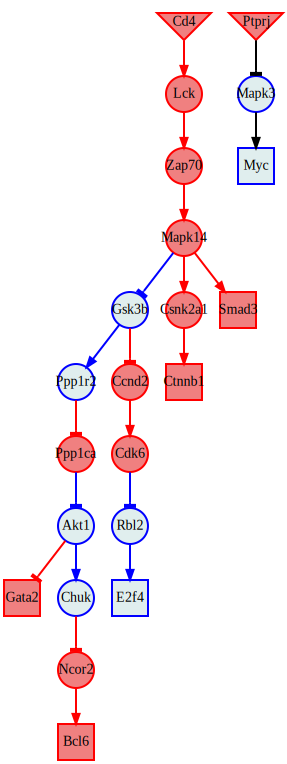

In [81]:
p

In [82]:
p.render(filename = '../plots/diff_network_KC_TGD_HDAC_cKO_vs_WT')

'../plots/diff_network_KC_TGD_HDAC_cKO_vs_WT.pdf'